In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
df = pd.read_csv('city_day.csv',index_col='Date', parse_dates=True)

In [3]:
df.columns

Index(['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')

In [4]:
df = df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6236 entries, 2017-11-25 to 2020-06-30
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        6236 non-null   object 
 1   PM2.5       6236 non-null   float64
 2   PM10        6236 non-null   float64
 3   NO          6236 non-null   float64
 4   NO2         6236 non-null   float64
 5   NOx         6236 non-null   float64
 6   NH3         6236 non-null   float64
 7   CO          6236 non-null   float64
 8   SO2         6236 non-null   float64
 9   O3          6236 non-null   float64
 10  Benzene     6236 non-null   float64
 11  Toluene     6236 non-null   float64
 12  Xylene      6236 non-null   float64
 13  AQI         6236 non-null   float64
 14  AQI_Bucket  6236 non-null   object 
dtypes: float64(13), object(2)
memory usage: 779.5+ KB


In [6]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000
mean,61.327365,123.418321,17.015191,31.708190,32.448956,20.737070,0.984344,11.514426,36.127691,3.700361,10.323696,2.557439,140.510103
std,53.709682,85.791491,20.037836,18.784041,27.388129,16.088215,1.356161,7.166113,19.553695,5.062159,12.287223,4.535060,92.738826
min,2.000000,7.800000,0.250000,0.170000,0.170000,0.120000,0.000000,0.710000,1.550000,0.000000,0.000000,0.000000,23.000000
25%,27.927500,66.970000,5.080000,15.977500,14.547500,10.390000,0.490000,6.557500,22.357500,0.910000,2.210000,0.300000,78.000000
50%,47.490000,103.010000,10.060000,28.900000,24.285000,14.690000,0.730000,9.875000,32.540000,2.435000,6.310000,1.250000,112.000000
75%,73.442500,150.770000,19.392500,43.632500,39.622500,28.545000,1.060000,14.430000,45.512500,4.620000,13.040000,3.030000,166.000000
max,639.190000,796.880000,159.220000,140.170000,224.090000,166.700000,16.230000,70.390000,162.330000,64.440000,103.000000,125.180000,677.000000


In [7]:
counts = df['City'].value_counts()
print(counts)



City
Hyderabad        1618
Delhi            1224
Visakhapatnam    1131
Amaravati         646
Amritsar          636
Kolkata           394
Chandigarh        277
Patna             191
Gurugram          119
Name: count, dtype: int64


In [8]:
hyderabad_rows = df[df['City'] == 'Hyderabad']
df = df[df['City'] == 'Hyderabad']

In [9]:
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-09-08,Hyderabad,91.82,32.94,5.41,28.93,23.37,24.94,0.48,7.98,27.04,1.01,5.74,0.68,179.0,Moderate
2015-09-09,Hyderabad,35.56,40.81,4.02,31.15,24.31,24.81,0.57,4.93,22.48,1.41,7.61,0.89,162.0,Moderate
2015-09-10,Hyderabad,45.64,44.89,7.06,28.96,25.58,24.80,0.73,5.29,24.69,1.25,7.84,0.85,76.0,Satisfactory
2015-09-11,Hyderabad,60.88,51.27,5.15,30.64,24.22,25.86,0.53,5.16,24.11,1.09,5.42,0.48,140.0,Moderate
2015-09-12,Hyderabad,65.61,41.31,3.40,26.03,20.37,24.78,0.57,5.44,25.47,0.83,4.39,0.22,128.0,Moderate


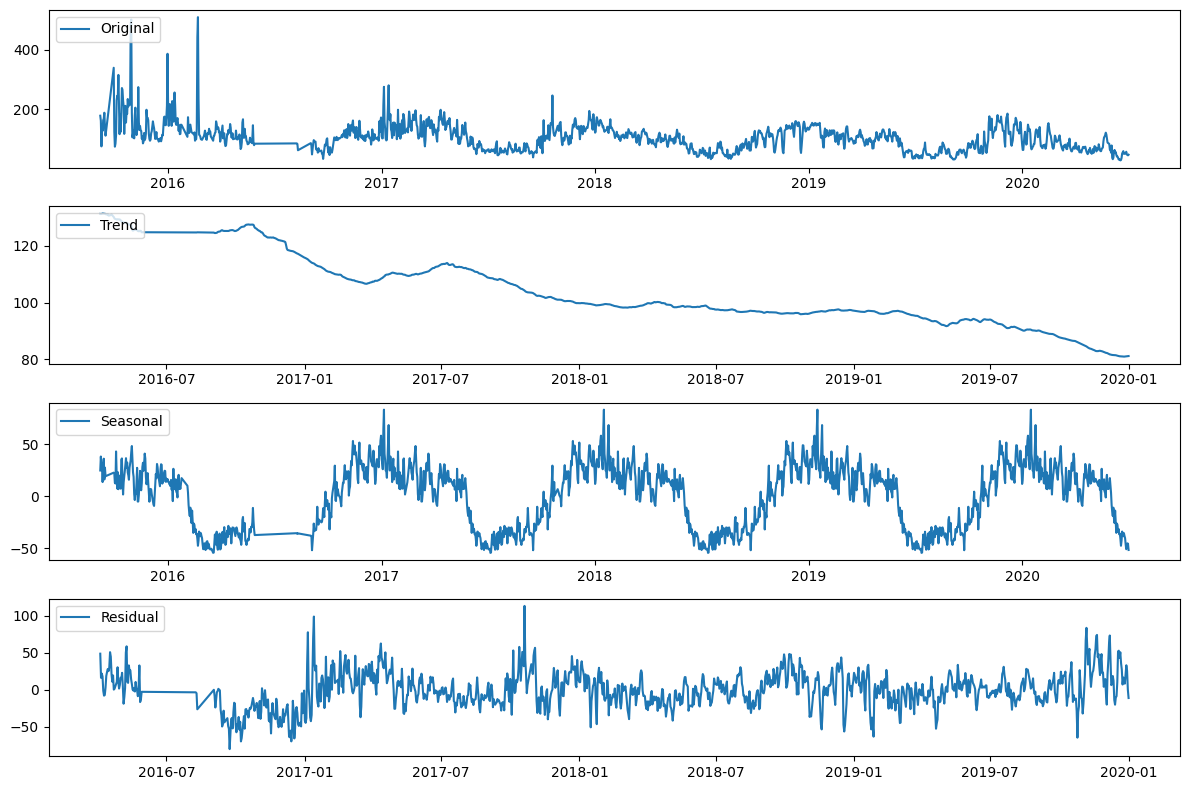

In [10]:
result = seasonal_decompose(df['AQI'], model='additive', period = 365)

#Trends, seasonality and residual data are plotted below
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['AQI'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
pollutants = df.select_dtypes(include = np.float64)
pollutants

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Date,,,,,,,,,,,,,
2015-09-08,91.82,32.94,5.41,28.93,23.37,24.94,0.48,7.98,27.04,1.01,5.74,0.68,179.0
2015-09-09,35.56,40.81,4.02,31.15,24.31,24.81,0.57,4.93,22.48,1.41,7.61,0.89,162.0
2015-09-10,45.64,44.89,7.06,28.96,25.58,24.80,0.73,5.29,24.69,1.25,7.84,0.85,76.0
2015-09-11,60.88,51.27,5.15,30.64,24.22,25.86,0.53,5.16,24.11,1.09,5.42,0.48,140.0
2015-09-12,65.61,41.31,3.40,26.03,20.37,24.78,0.57,5.44,25.47,0.83,4.39,0.22,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,23.29,44.20,6.38,22.64,15.39,9.34,0.36,5.39,24.22,0.88,6.72,0.95,58.0
2020-06-28,15.80,32.18,5.79,22.73,14.89,11.09,0.36,6.36,22.25,0.82,6.48,1.11,49.0
2020-06-29,20.24,44.74,3.96,27.59,17.09,13.09,0.38,6.29,19.98,1.31,10.83,2.71,47.0


In [12]:
pollutants.corr().AQI

PM2.5      0.866114
PM10       0.680515
NO         0.239406
NO2        0.265958
NOx        0.284195
NH3        0.232307
CO         0.422720
SO2        0.295046
O3         0.475000
Benzene    0.272830
Toluene    0.240822
Xylene     0.149622
AQI        1.000000
Name: AQI, dtype: float64

In [13]:
AQI = df['AQI']

In [14]:
y = pollutants.AQI
X = pollutants.drop(columns = 'AQI')

In [15]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [16]:
WINDOW_SIZE = 7
X, y = df_to_X_y(AQI, WINDOW_SIZE)
X.shape, y.shape

((1611, 7, 1), (1611,))

In [17]:
scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

total_samples = len(df)

# Calculate the split point
split_point = int(total_samples * 0.75)

# create training and testing sets
X_train, y_train = X[:split_point], y[:split_point]
X_test, y_test = X[split_point:], y[split_point:]

# check to ensure split is correct
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 1213
Testing set size: 398


In [18]:
# Create and train linear regression model
model = tf.keras.models.Sequential()
model.add(InputLayer((7,)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

model.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(X_train, y_train, epochs=10, verbose=0,validation_split=0.1)

# Evaluate the model
mse, mae = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
#print("R2 Score:", r2_score)







13/13 [==============================] - 0s 4ms/step - loss: 271.7643 - mean_absolute_error: 12.2802
Mean Squared Error: 271.7642822265625
Mean Absolute Error: 12.280220985412598


In [19]:
# Plot the predictions against the actual values
predictions = model.predict(X_test)
predictions = predictions.flatten()[:len(y_test)]
results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_test})
results


13/13 [==============================] - 0s 4ms/step


,Predictions,Actuals
0,121.731071,105.0
1,114.627098,95.0
2,111.054138,111.0
3,122.016304,91.0
4,99.798393,75.0
...,...,...
393,55.286407,58.0
394,60.480381,49.0
395,53.550632,47.0
396,52.052765,46.0


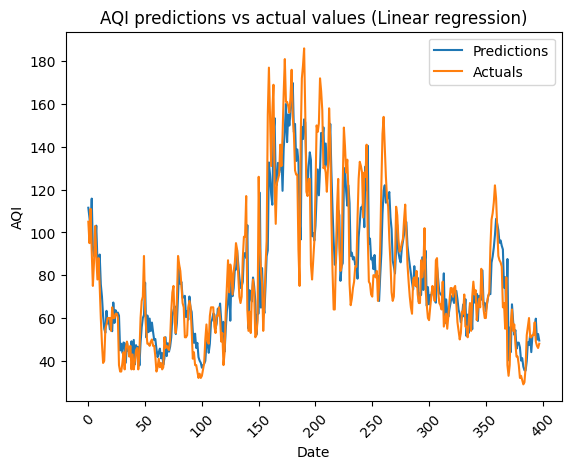

In [32]:
plt.plot(results['Predictions'], label="Predictions")
plt.plot(results['Actuals'], label = "Actuals")
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI predictions vs actual values (Linear regression)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [22]:

# Create and train TensorFlow LSTM model
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model1.fit(X_train, y_train, epochs=100, verbose=0)

# Evaluate the model
mae, mse = model1.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
#print("R2 Score:", r2_score)

# Plot actual vs. predicted values

13/13 [==============================] - 1s 6ms/step - loss: 203.9901 - mean_absolute_error: 10.4474
Mean Squared Error: 10.447402000427246
Mean Absolute Error: 203.99008178710938


In [23]:
predictions = model1.predict(X_test)
predictions = predictions.flatten()[:len(y_test)]
results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_test})
results

13/13 [==============================] - 1s 5ms/step


,Predictions,Actuals
0,114.128304,105.0
1,104.676613,95.0
2,97.963829,111.0
3,112.552353,91.0
4,91.513878,75.0
...,...,...
393,54.361919,58.0
394,58.998852,49.0
395,51.796097,47.0
396,51.084656,46.0


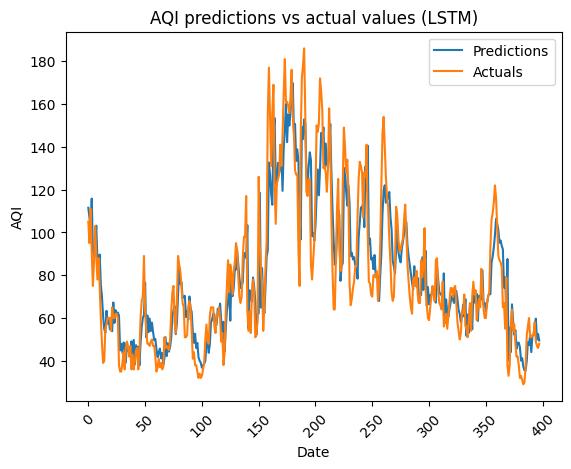

In [33]:
plt.plot(results['Predictions'], label="Predictions")
plt.plot(results['Actuals'], label = "Actuals")
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI predictions vs actual values (LSTM)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

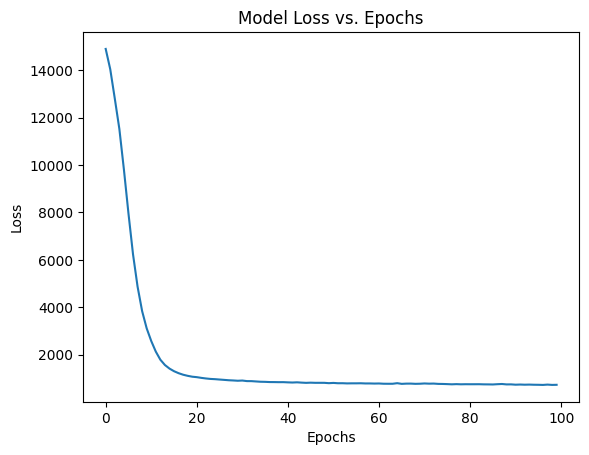

In [25]:
# loss versus epochs
plt.plot(history.history['loss'])
plt.title('Model Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
model2 = Sequential()
model2.add(InputLayer((7, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))


In [28]:
model2.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model2.fit(X_train, y_train, epochs=10, verbose=0)

# Evaluate the model
mae = model2.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
#print("R2 Score:", r2_score)

13/13 [==============================] - 0s 4ms/step - loss: 230.9763 - mean_absolute_error: 11.0761
Mean Squared Error: 10.447402000427246
Mean Absolute Error: [230.97628784179688, 11.076143264770508]


In [29]:
predictions = model2.predict(X_test)
predictions = predictions.flatten()[:len(y_test)]
results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_test})
results

13/13 [==============================] - 0s 5ms/step


,Predictions,Actuals
0,111.531769,105.0
1,106.871399,95.0
2,101.674820,111.0
3,115.806549,91.0
4,92.300613,75.0
...,...,...
393,55.563801,58.0
394,59.705456,49.0
395,49.832462,47.0
396,52.552265,46.0


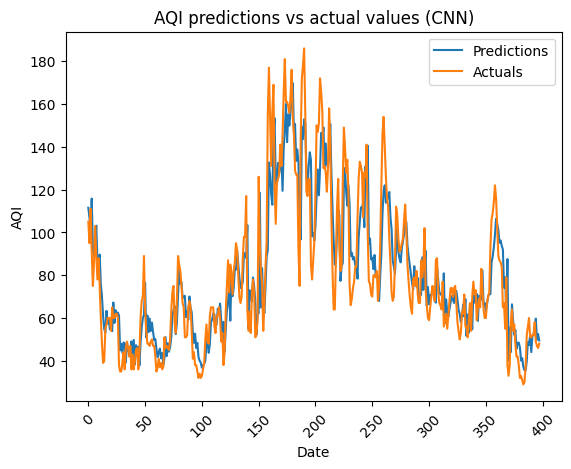

In [38]:
plt.plot(results['Predictions'], label="Predictions")
plt.plot(results['Actuals'], label = "Actuals")
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI predictions vs actual values (CNN)')
plt.xticks(rotation=45)
plt.legend()
plt.show()